# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.inspection import plot_partial_dependence

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [ ]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

In [ ]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [ ]:
y_train

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [ ]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

In [ ]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

### Fit

Let's fit a model and plot the hypothesis it learns:

In [ ]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

In [ ]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [ ]:
DEGREES[np.argmin(rmse_valid)]

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

In [ ]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [ ]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

In [ ]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

In [ ]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

In [ ]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [5]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [6]:
# your findings/conclusions
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.1, random_state=SEED)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=SEED)


In [7]:
DEGREES = np.linspace(1, 15, 0 + 15, dtype=int)

Let's skip a scale step in our Model becayse each of these 10 feature variables have been mean centered and scaled.

In [8]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        #('sca', StandardScaler()),
        ('reg', regressor)
    ])

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [10]:
def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()

In [11]:
def plot_fit(model, X_range, y_range):
    degree = model['pol'].degree
    XYP_range = pd.concat([X_range, y_range, pd.DataFrame(model.predict(X_range))], axis=1)
    columns = X_range.columns

    column_pair = {}
    for column in columns:
        XYP_range = XYP_range.sort_values(by = column)
        column_pair[column] = pd.concat([XYP_range[column], XYP_range['target'], XYP_range[0]], axis=1) 
        
    fig, ax = plt.subplots(figsize=(20, 10))
    mlp_disp = plot_partial_dependence(model, X_range, columns, ax=ax)
    for i in range(len(columns)):
        lev = int(i / 3)
        shift = int(i % 3)
        mlp_disp.axes_[lev, shift].scatter(column_pair[columns[i]][columns[i]], column_pair[columns[i]]['target'], label='Original of ' + columns[i])
        mlp_disp.axes_[lev, shift].scatter(column_pair[columns[i]][columns[i]], column_pair[columns[i]][0], label='Predict  of ' + columns[i])
        mlp_disp.axes_[lev, shift].legend(loc='best')
        
    ax.set_title(f'Polynomial approximation: degree={degree}')

I would like to see polynomial regression for all features of the data set. As there is no possibility to calculate all 15 degrees I set just 10 degrees only for the experiment. And then I will select just a few features for this exercise.

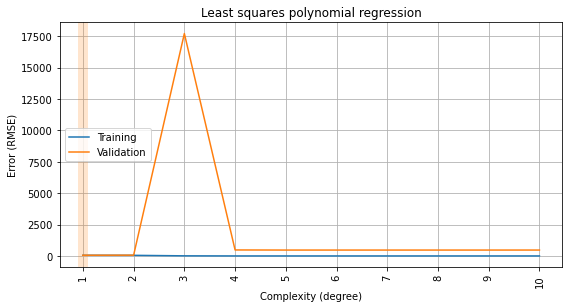

In [12]:
rmse_train, rmse_test = [], []
for degree in np.linspace(1, 10, 0 + 10, dtype=int):
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_test.append(rmse(reg.predict(X_test), y_test))
    
plot_fitting_graph(np.linspace(1, 10, 0 + 10, dtype=int), rmse_train, rmse_test, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

Let's prepare a list of feature for regularization methods task.

In [13]:
xy_df = pd.concat([X_train, y_train], axis=1)  

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.169027,0.156811,0.394704,0.261202,0.210707,-0.073549,0.181514,0.287794,0.327331,0.193475
sex,0.169027,1.000000,0.055442,0.223585,0.024139,0.113352,-0.383649,0.315986,0.171328,0.171679,0.030009
bmi,0.156811,0.055442,1.000000,0.370863,0.221530,0.243319,-0.416201,0.424745,0.431332,0.375932,0.602021
bp,0.394704,0.223585,0.370863,1.000000,0.253426,0.176441,-0.134641,0.215512,0.389998,0.373648,0.410668
s1,0.261202,0.024139,0.221530,0.253426,1.000000,0.901289,-0.018789,0.576861,0.524761,0.338221,0.189744
s2,0.210707,0.113352,0.243319,0.176441,0.901289,1.000000,-0.237996,0.674405,0.326359,0.299962,0.154700
s3,-0.073549,-0.383649,-0.416201,-0.134641,-0.018789,-0.237996,1.000000,-0.754802,-0.452678,-0.315156,-0.427538
s4,0.181514,0.315986,0.424745,0.215512,0.576861,0.674405,-0.754802,1.000000,0.648622,0.449125,0.438470
s5,0.287794,0.171328,0.431332,0.389998,0.524761,0.326359,-0.452678,0.648622,1.000000,0.481999,0.558535
s6,0.327331,0.171679,0.375932,0.373648,0.338221,0.299962,-0.315156,0.449125,0.481999,1.000000,0.375889


<AxesSubplot:>

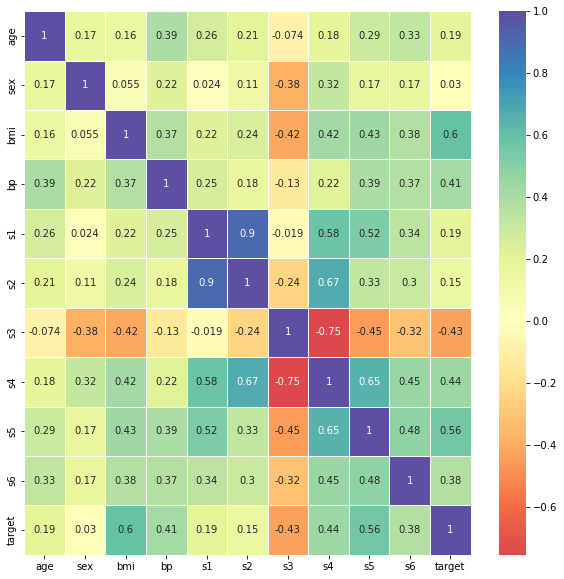

In [14]:
correlation_matrix = pd.DataFrame.corr(pd.DataFrame(xy_df)) 
display(correlation_matrix)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(correlation_matrix, center=0,  cmap="Spectral", annot = True, linewidths=.5, ax=ax)

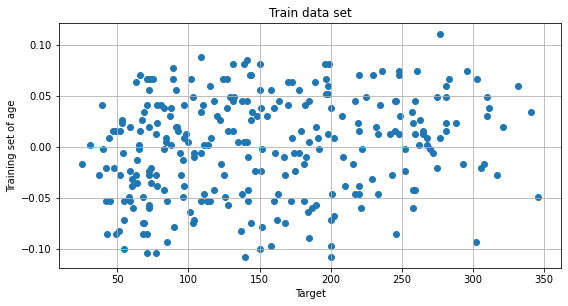

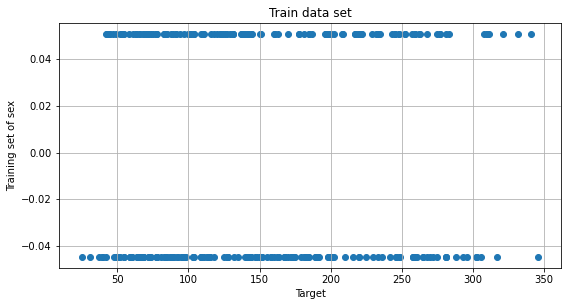

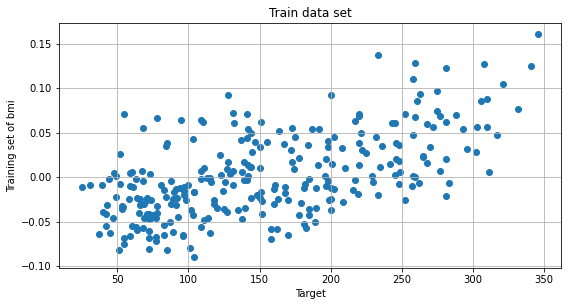

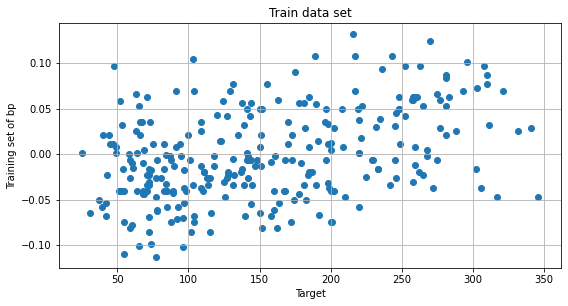

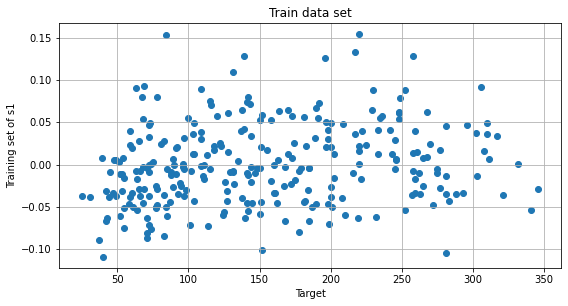

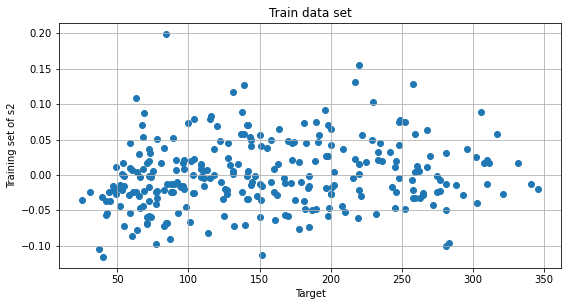

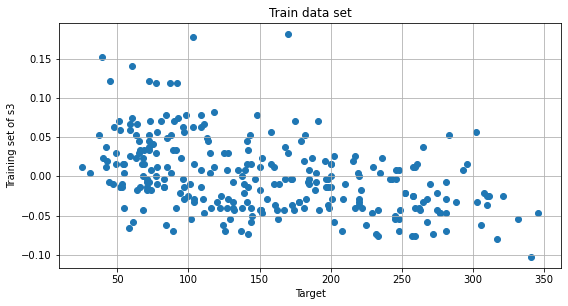

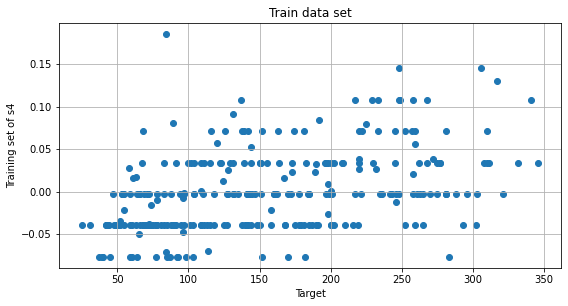

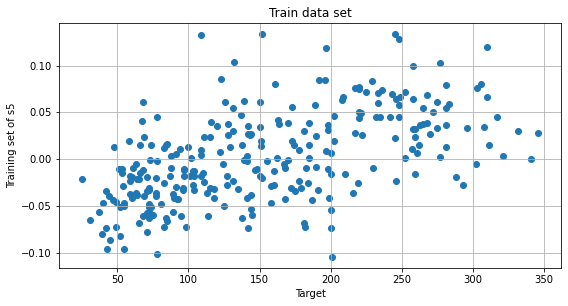

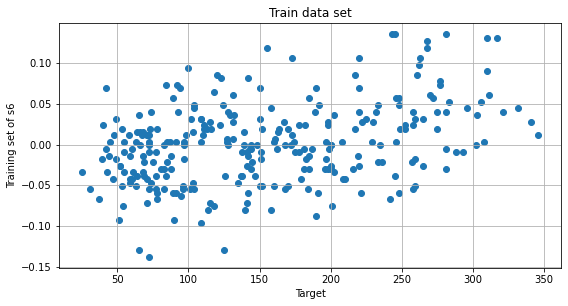

In [15]:
for column in X_train.columns:
    plt.figure(figsize=(9, 4.5))
    plt.scatter(y_train['target'], X_train[column])
    plt.title("Train data set")
    plt.ylabel('Training set of ' + column)
    plt.xlabel("Target")
    plt.grid(True)
    plt.show()


In [16]:
features = ['bmi', 's4', 's5']

In [17]:
X_train = X_train[features]
X_test = X_test[features]
X_valid = X_valid[features]

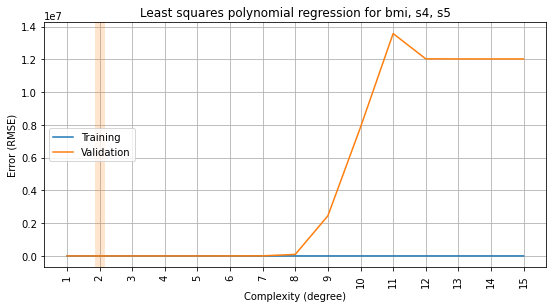

In [18]:
rmse_train, rmse_test = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_test.append(rmse(reg.predict(X_test), y_test))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_test, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression for ' + ', '.join(features))

In [19]:
DEGREES[np.argmin(rmse_test)]

2

In [20]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=3).fit(X_train, y_train)['reg'].coef_)

(array([[738.94705574,  34.90618299, 579.50427193]]),
 array([[  663.88214604,    48.40374496,   609.51478827,  1572.97901039,
           -56.60983936,  1186.37037638,   666.74453773, -1562.00720655,
          -697.38584306]]),
 array([[ 6.53553033e+02, -1.79430981e+01,  7.78667680e+02,
          1.34052462e+03, -1.85182885e+03,  2.94187281e+03,
          3.20451535e+03, -4.68015158e+03,  7.57705797e+02,
          7.44135313e+03,  2.68376409e+04, -3.81713768e+04,
          3.85528907e+04, -1.16173493e+05,  2.20912593e+04,
         -3.71697801e+04,  8.66468160e+04,  1.60836199e+04,
         -4.24834777e+04]]))

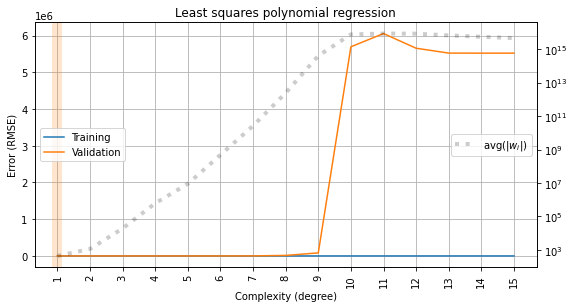

In [21]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X_diabetes[features], y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

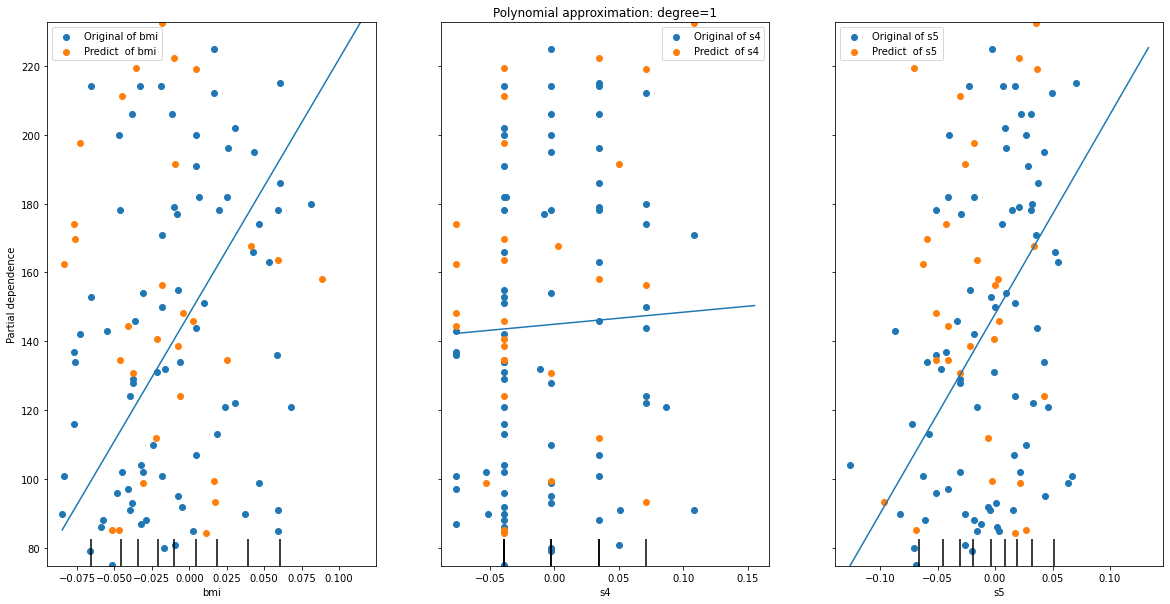

In [26]:
plot_fit(make_model(degree=1).fit(X_train, y_train), X_test, y_test)

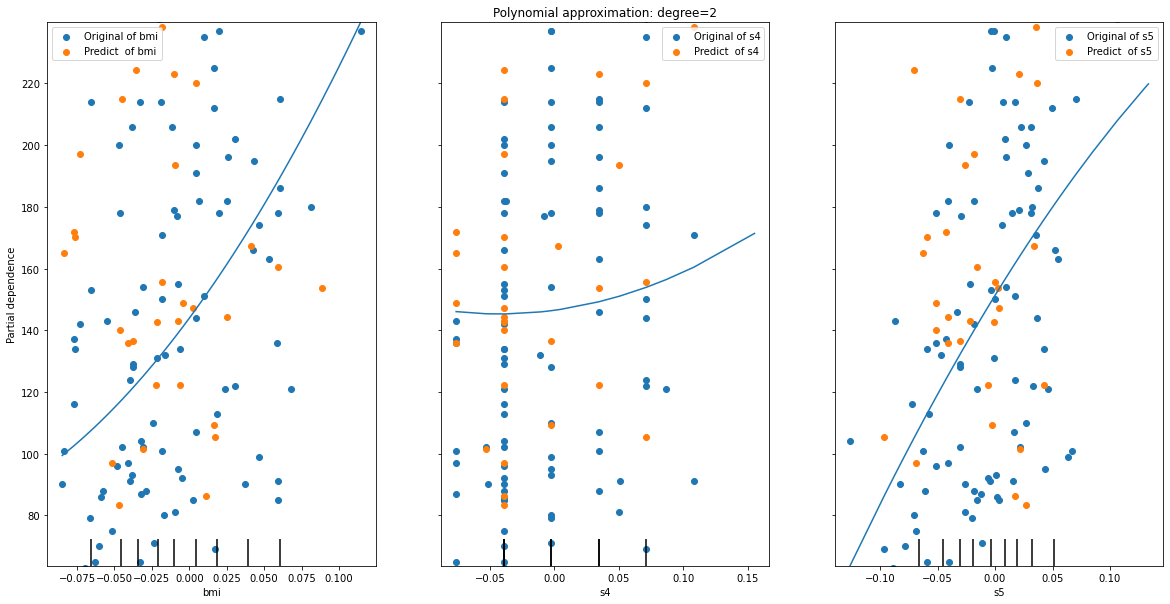

In [27]:
plot_fit(make_model(degree=2).fit(X_train, y_train), X_test, y_test)

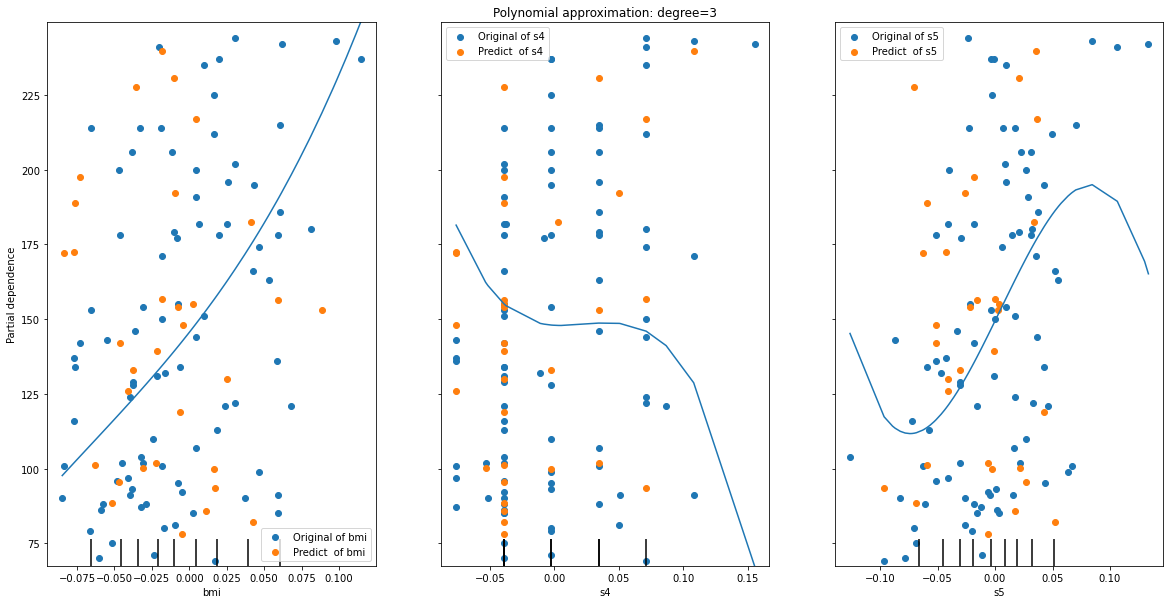

In [28]:
plot_fit(make_model(degree=3).fit(X_train, y_train), X_test, y_test)

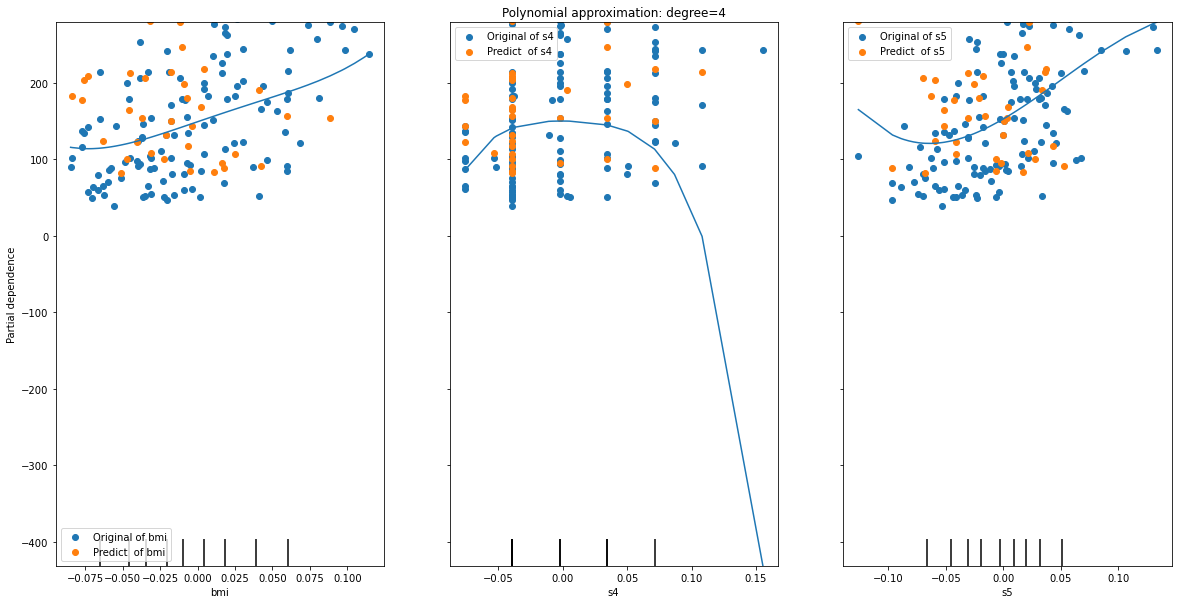

In [29]:
plot_fit(make_model(degree=4).fit(X_train, y_train), X_test, y_test)

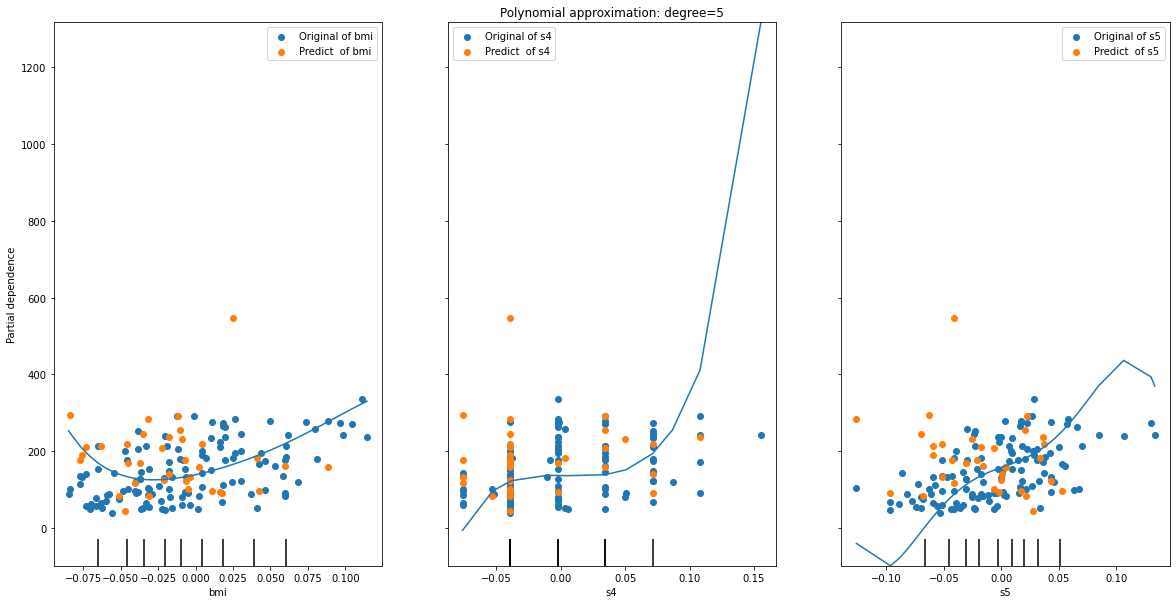

In [30]:
plot_fit(make_model(degree=5).fit(X_train, y_train), X_test, y_test)

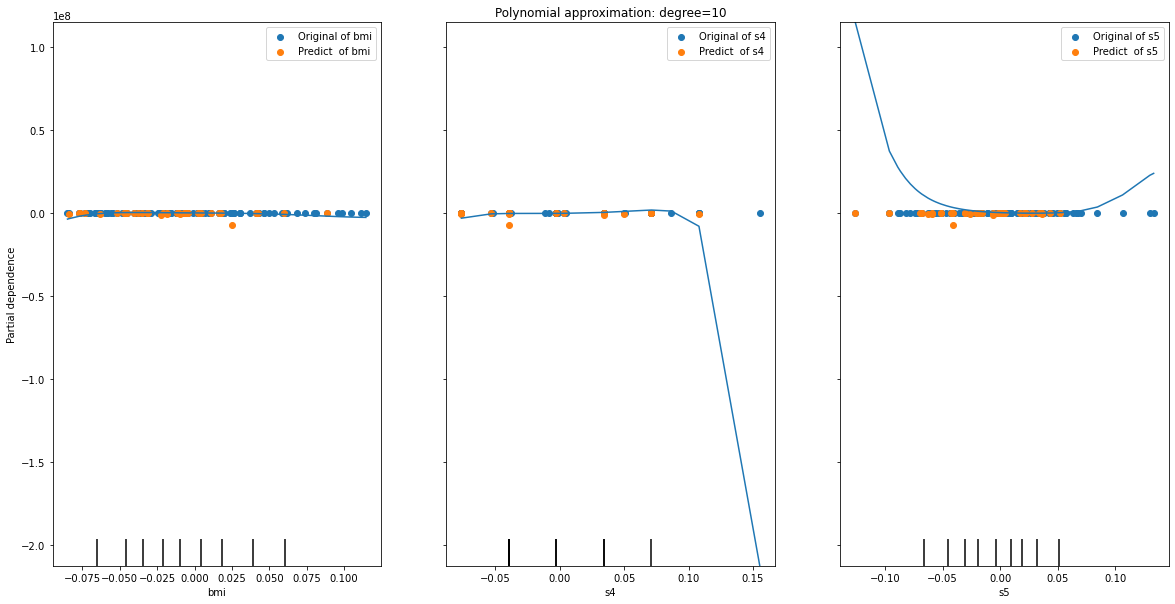

In [31]:
plot_fit(make_model(degree=10).fit(X_train, y_train), X_test, y_test)

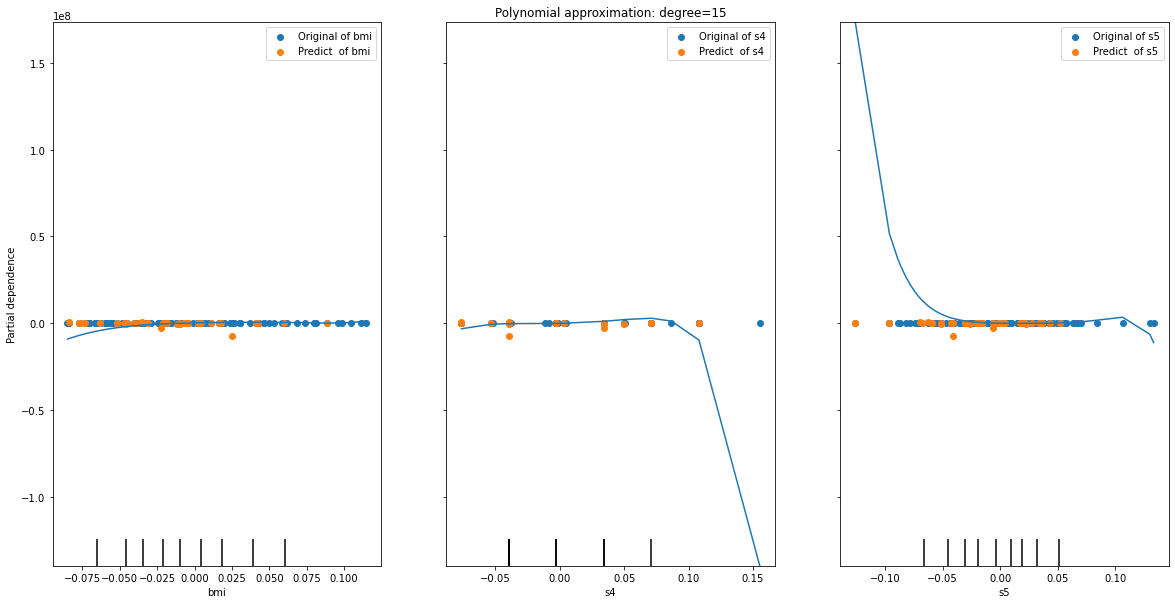

In [32]:
plot_fit(make_model(degree=15).fit(X_train, y_train), X_test, y_test)

### Summary

Plots the dependence of train and test error on polynomial degree shows the behavior of the target predicted function. The plots help to detect a proper degree with the best test errors, which will be not overfitting or not underfitting. All higher degrees will have a lot of turns/rotation and try to go via train set as much as possible which is named as overfitting. The model starts fitting the noise in the dataset. Such prediction is not able to get good results for a valid data set.  Underfitting shows less convenient results than expected.

As for me, 1 or 2 degrees can be the right level. It seems that this should be investigated next.  


### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

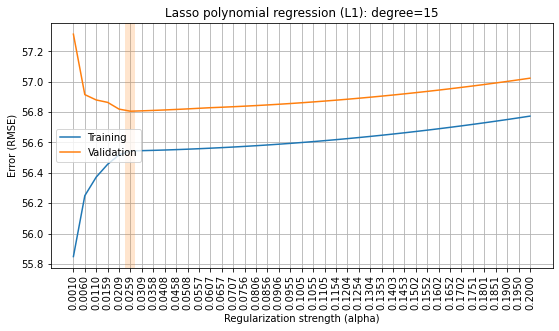

In [23]:
## your code
rmse_train, rmse_valid = [], []
ALPHAS = np.linspace(0.001, 0.2, 1 + 40)
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes[features], y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

#### L2

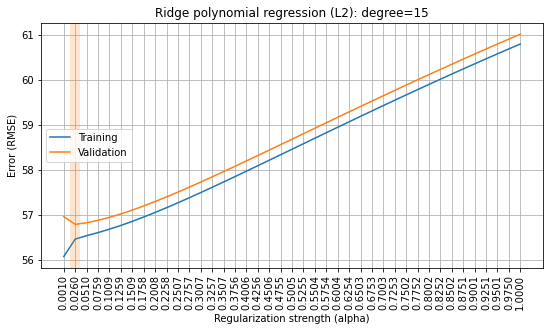

In [25]:
## your code
ALPHAS = np.linspace(0.001, 1, 1 + 40)
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes[features], y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

In [33]:
model_1_l1 = make_model(degree=1, penalty='L1', alpha=0.0259).fit(X_train, y_train)
model_2_l1 = make_model(degree=2, penalty='L1', alpha=0.0259).fit(X_train, y_train)
model_3_l1 = make_model(degree=3, penalty='L1', alpha=0.0259).fit(X_train, y_train)
model_1_l2 = make_model(degree=1, penalty='L2', alpha=0.0260).fit(X_train, y_train)
model_2_l2 = make_model(degree=2, penalty='L2', alpha=0.0260).fit(X_train, y_train)
model_3_l2 = make_model(degree=3, penalty='L2', alpha=0.0260).fit(X_train, y_train)

In [34]:
print('L1 with Degree = 1, RMSE = ', rmse(model_1_l1.predict(X_train), y_train))
print('L1 with Degree = 2, RMSE = ', rmse(model_2_l1.predict(X_train), y_train))
print('L1 with Degree = 3, RMSE = ', rmse(model_3_l1.predict(X_train), y_train))
print('L2 with Degree = 1, RMSE = ', rmse(model_1_l2.predict(X_train), y_train))
print('L2 with Degree = 2, RMSE = ', rmse(model_2_l2.predict(X_train), y_train))
print('L2 with Degree = 3, RMSE = ', rmse(model_3_l2.predict(X_train), y_train))

L1 with Degree = 1, RMSE =  56.866043821920286
L1 with Degree = 2, RMSE =  56.866043821920286
L1 with Degree = 3, RMSE =  56.866043821920286
L2 with Degree = 1, RMSE =  56.89120884254369
L2 with Degree = 2, RMSE =  56.82453414734696
L2 with Degree = 3, RMSE =  56.82357580337654


In [39]:
print('L1 with Degree = 2, RMSE = ', rmse(model_1_l1.predict(X_test), y_test))
print('L2 with Degree = 2, RMSE = ', rmse(model_1_l2.predict(X_test), y_test))

L1 with Degree = 2, RMSE =  57.98581596979065
L2 with Degree = 2, RMSE =  57.7559227385343


Let's check how model coefficients were changed.

In [38]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=3).fit(X_train, y_train)['reg'].coef_)

(array([[738.94705574,  34.90618299, 579.50427193]]),
 array([[  663.88214604,    48.40374496,   609.51478827,  1572.97901039,
           -56.60983936,  1186.37037638,   666.74453773, -1562.00720655,
          -697.38584306]]),
 array([[ 6.53553033e+02, -1.79430981e+01,  7.78667680e+02,
          1.34052462e+03, -1.85182885e+03,  2.94187281e+03,
          3.20451535e+03, -4.68015158e+03,  7.57705797e+02,
          7.44135313e+03,  2.68376409e+04, -3.81713768e+04,
          3.85528907e+04, -1.16173493e+05,  2.20912593e+04,
         -3.71697801e+04,  8.66468160e+04,  1.60836199e+04,
         -4.24834777e+04]]))

In [36]:
(model_1_l1['reg'].coef_,
 model_2_l1['reg'].coef_,
 model_3_l1['reg'].coef_)


(array([731.31687155,  30.02062052, 574.61570656]),
 array([731.31687155,  30.02062052, 574.61570656,   0.        ,
          0.        ,   0.        ,   0.        ,  -0.        ,
         -0.        ]),
 array([731.31687155,  30.02062052, 574.61570656,   0.        ,
          0.        ,   0.        ,   0.        ,  -0.        ,
         -0.        ,   0.        ,   0.        ,  -0.        ,
          0.        ,  -0.        ,  -0.        ,  -0.        ,
          0.        ,  -0.        ,  -0.        ]))

In [37]:
(model_1_l2['reg'].coef_,
 model_2_l2['reg'].coef_,
 model_3_l2['reg'].coef_)


(array([[708.4286344 ,  63.01624918, 551.48067557]]),
 array([[701.71379758,  64.19719193, 554.00581646, 158.9035412 ,
          59.68742523,  69.04305827,  12.63050499, -50.0228419 ,
         -72.92688127]]),
 array([[701.58210492,  64.23219378, 554.10610992, 158.80711945,
          59.66841111,  69.02120322,  12.68519178, -49.99049798,
         -72.86952505,  16.82273643,   5.09606852,  -1.10386984,
           1.96143229,  -1.37377661,  -1.39821996,  -7.3257505 ,
           5.8078063 ,  -2.28943232, -15.06859186]]))

In [44]:
model_1_l1.score(X_test, y_test), model_1_l1.score(X_valid, y_valid)

(0.3755034686265881, 0.5668260356163283)

In [45]:
model_1_l2.score(X_test, y_test), model_1_l2.score(X_valid, y_valid)

(0.38044546783464206, 0.5657030519707121)

#### Summary

L1_alpha = 0.0259
L2_alpha = 0.0260

Regularization methods constrain the weights (model coefficients) or restrict the sizes of the coefficients which helps a predictive model to be less biased and well-performing.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

In [ ]:
## your code
for degree in DEGREES:
    coef = make_model(degree, penalty='L1', alpha=L1_alpha).fit(X_train, y_train)['reg'].coef_
    coef_total = len(coef)
    coef_zero_count = coef_total - np.count_nonzero(coef)
    print("DEGREE = ", degree, "; ZEROS = ",  coef_zero_count, " -> ", 100 * coef_zero_count / coef_total, "%")


#### L2

In [ ]:
for degree in DEGREES:
    coef = make_model(degree, penalty='L2', alpha=L2_alpha).fit(X_train, y_train)['reg'].coef_[0]
    coef_total = len(coef)
    coef_zero_count = coef_total - np.count_nonzero(coef)
    print("DEGREE = ", degree, "; ZEROS = ",  coef_zero_count, " -> ", 100 * coef_zero_count / coef_total, "%")


#### Summary

Lasso (L1) method makes coefficients as zeros, unlike Ridge (L2) method which never makes zero coefficients. 
This is the main difference between 2 methods.


### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [47]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [48]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])



In [49]:
def make_model_no_sca(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('reg', regressor)
    ])


In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X_hw, y_hw, test_size=0.75, random_state=SEED)

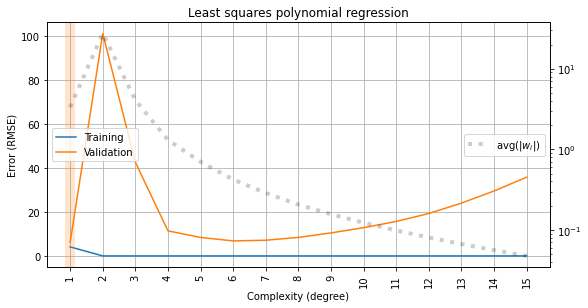

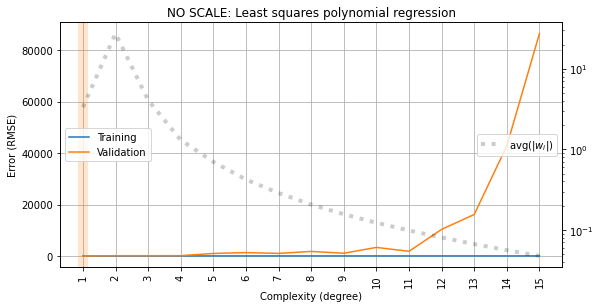

In [51]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []
rmse_train_no_sca, rmse_valid_no_sca, avg_coef_no_sca = [], [], []

for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X_train, y_train, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    # NO SCALING
    results = cross_validate(make_model_no_sca(degree),
                         X_train, y_train, cv=5,
                         return_train_score=True, return_estimator=True,
                         scoring='neg_root_mean_squared_error')
    rmse_train_no_sca.append(-np.mean(results['train_score']))
    rmse_valid_no_sca.append(-np.mean(results['test_score'])) 
    avg_coef_no_sca.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))

    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')
    
plot_fitting_graph(DEGREES, rmse_train_no_sca, rmse_valid_no_sca,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='NO SCALE: Least squares polynomial regression')

#### L1

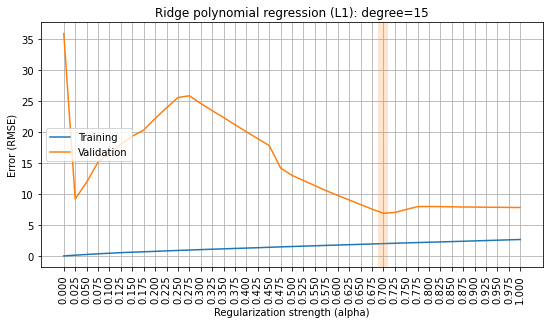

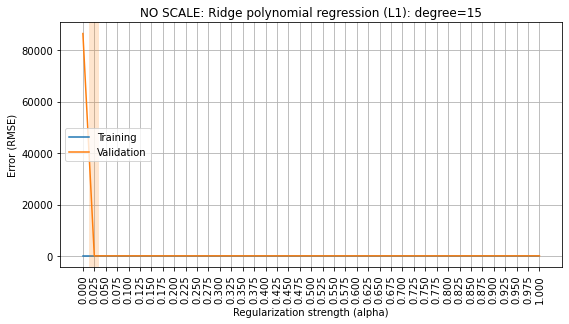

In [52]:
## your code
ALPHAS = np.linspace(0, 1, 1 + 40)
rmse_train, rmse_valid = [], []
rmse_train_no_scale, rmse_valid_no_scale = [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_train, y_train, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    # NO SCALE
    results = cross_validate(make_model_no_sca(degree=15, penalty='L1', alpha=alpha), 
                             X_train, y_train, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_no_scale.append(-np.mean(results['train_score']))
    rmse_valid_no_scale.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L1): degree=15')
plot_fitting_graph(ALPHAS, rmse_train_no_scale, rmse_valid_no_scale, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='NO SCALE: Ridge polynomial regression (L1): degree=15')

#### L2

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.09082e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.44982e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matr

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.09082e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.44982e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matr

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.09082e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.44982e-18): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


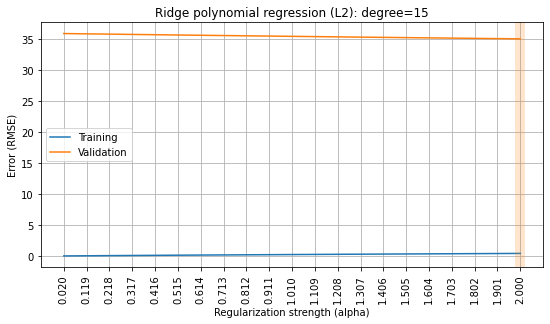

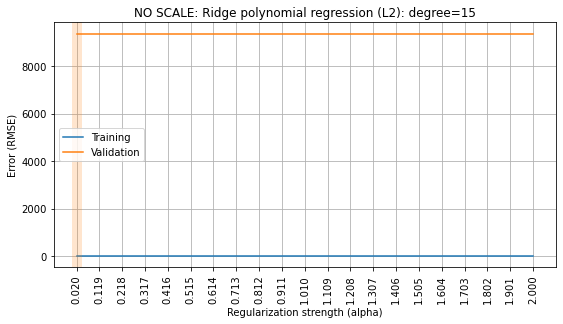

In [55]:
## your code
## your code
ALPHAS = np.linspace(0.02, 2, 1 + 20)
rmse_train, rmse_valid = [], []
rmse_train_no_scale, rmse_valid_no_scale = [], []

for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_train, y_train, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    # NO SCALE
    results = cross_validate(make_model_no_sca(degree=15, penalty='L2', alpha=alpha), 
                             X_train, y_train, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train_no_scale.append(-np.mean(results['train_score']))
    rmse_valid_no_scale.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')
plot_fitting_graph(ALPHAS, rmse_train_no_scale, rmse_valid_no_scale, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='NO SCALE: Ridge polynomial regression (L2): degree=15')

In [56]:
(make_model(degree = 1, penalty='L1', alpha=0.700).fit(X_train, y_train)['reg'].coef_,
 make_model(degree = 2, penalty='L1', alpha=0.700).fit(X_train, y_train)['reg'].coef_)


(array([ 4.41171437,  0.05758169, -1.67490523]),
 array([ 0.        ,  0.        , -0.        ,  0.        , -1.01014962,
         6.0561263 ,  0.        ,  0.38067877, -2.42264507]))

In [59]:
(make_model_no_sca(degree = 1, penalty='L1', alpha=0.025).fit(X_train, y_train)['reg'].coef_,
 make_model_no_sca(degree = 2, penalty='L1', alpha=0.025).fit(X_train, y_train)['reg'].coef_)

(array([ 1.77577536e+02,  2.11439539e-03, -4.48991437e-02]),
 array([ 0.00000000e+00, -1.88131103e-02, -1.96499668e-01, -0.00000000e+00,
        -6.66028535e-01,  2.83586673e+00, -3.54658309e-05,  2.04386649e-04,
         5.31162387e-04]))

In [60]:
(make_model(degree = 1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree = 2).fit(X_train, y_train)['reg'].coef_)

(array([ 5.93928594,  1.13543311, -2.6686638 ]),
 array([  9.51309194, -12.16677366, -25.07253406,   1.21781846,
         -9.87539813,  -0.52333537,  -6.1414033 ,  13.59467665,
         20.59276629]))

In [61]:
(make_model_no_sca(degree = 1).fit(X_train, y_train)['reg'].coef_,
 make_model_no_sca(degree = 2).fit(X_train, y_train)['reg'].coef_)

(array([ 2.26038175e+02,  3.43571789e-03, -5.20619859e-02]),
 array([ 3.62050584e+02, -3.68155567e-02, -4.89130896e-01,  1.58386115e+03,
        -1.20810783e+00, -1.74917562e-01, -7.57662418e-05,  3.48590939e-04,
         1.80654871e-03]))

Scaling makes the data set closer to each other, in other words,  the distance between them will be lower. It allows having model coefficients lower and decreases the total wights.

#### Summary



## your observations/conclusions

* Polynomial Regression supports model non-linearly separable data. It is much more flexible in general and can model some fairly complex relationships.
* Plots the dependence of train and test error on polynomial degree shows the behavior of the target predicted function. The plots help to detect a proper degree with the best test errors, which will be not overfitting or not underfitting. All higher degrees will have a lot of turns/rotation and try to go via train set as much as possible which is named overfitting.  The model starts fitting the noise in the dataset. Such prediction is not able to get good results for a valid data set.  Underfitting shows less convenient results than expected.
* Lasso (L1) and Ridge (L2) are the most common methods of regularization.
* Lasso is a regression analysis method that adds a regularization penalty to the loss function during training.
* Ridge is a regression analysis method that shrinks the value of coefficients but doesn’t reach zero, which suggests no feature selection feature.
* Lasso (L1) method makes coefficients as zeros, unlike Ridge (L2) method which never makes zero coefficients. This is the main difference between the 2 methods.
* Lasso sometimes struggles with data. If a model includes a scale stage, Lasso calculation is not able to finish for 4 or more features. According to my own experience of my assignment, Ridge calculated quicker. 
* Regularization methods constrain the weights (model coefficients) or restrict the sizes of the coefficients which helps a predictive model to be less biased and well-performing.
* Scaling makes the data set closer to each other, in other words,  the distance between them will be lower. It allows having model coefficients lower and decreases the total wights.